Import av nødvendige moduler

In [3]:
import sys
import os
src_path = "..\\src"
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy
import functions as fc

Hente inn og forberede data

In [4]:
# Hente inn datasett fra data
csv_prcp = pd.read_csv("../data/precipitation.csv")

# Endre tidshenvisning til datetime-format
fc.make_datetime(csv_prcp)
fc.label_tidsforskyvning(csv_prcp)

referansetid er gjort om til DateTime
tidsforskyvning har fått labels


Visualisere resultater

Gjennomsnittlig verdi for datasettet er 3.28 mm


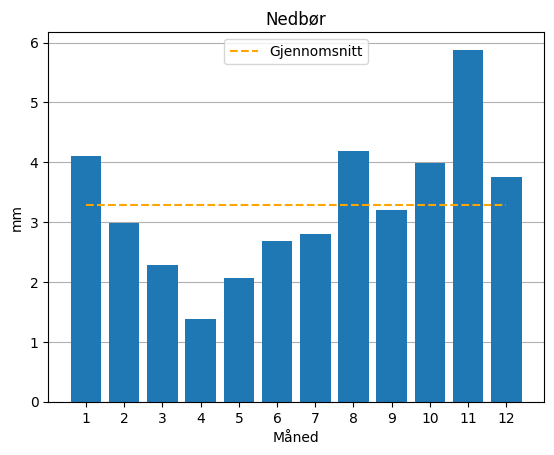

In [5]:
# Regne ut gjennomsnittlig nedbør over tid
fc.average_year(csv_prcp)
monthly_prcp = fc.average_month(csv_prcp)

# Visualisere månedlig gjennomsnitt
fc.average_month_bargraph(monthly_prcp, 'Nedbør', 'mm')